In [1]:
# For reproducibility, please pip install the following libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# Q4
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression


## Problem 1 -  Bias Variance Tradeoff

### 1.1. Create a dataset, display the dataset and f(x) in one plot.

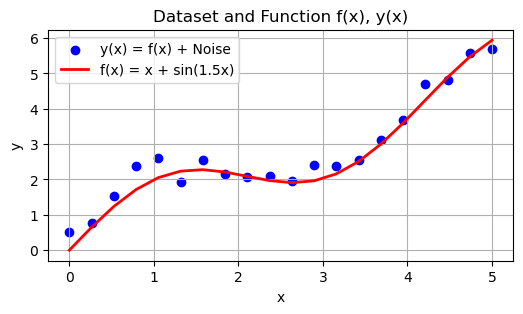

In [13]:

# Set the seed for reproducibility
np.random.seed(0)

# 20 random samples for x in the range [0, 5]
x = np.linspace(0, 5, 20)

# fx
f_x = x + np.sin(1.5 * x)

# yx
epsilon = np.random.normal(0, 0.3, size=x.size)
y_x = f_x + epsilon

# plot
plt.figure(figsize=(6, 3))
plt.scatter(x, y_x, color='blue', label='y(x) = f(x) + Noise')
plt.plot(x, f_x, color='red', linewidth=2, label='f(x) = x + sin(1.5x)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Dataset and Function f(x), y(x)')
plt.legend()
plt.grid()
plt.show()


### 1.2. Estimate coefficients, plotting

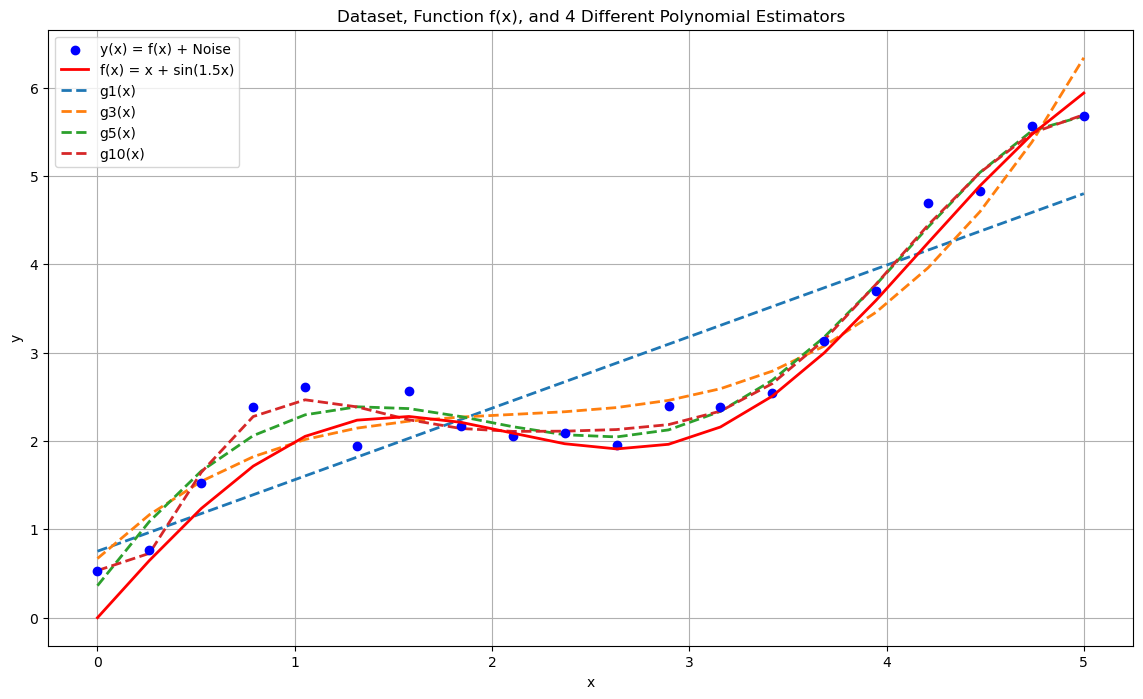

In [14]:

# Define estimator degrees
degrees = [1, 3, 5, 10]

plt.figure(figsize=(14, 8))
plt.scatter(x, y_x, color='blue', label='y(x) = f(x) + Noise', zorder=5)
plt.plot(x, f_x, color='red', linewidth=2, label='f(x) = x + sin(1.5x)', zorder=6)

# Fit and plot
for degree in degrees:
    poly = PolynomialFeatures(degree=degree)
    x_poly = poly.fit_transform(x[:, np.newaxis])
    
    model = LinearRegression()
    model.fit(x_poly, y_x)
    y_pred = model.predict(x_poly)
    
    plt.plot(x, y_pred, label=f'g{degree}(x)', linewidth=2, linestyle='--')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Dataset, Function f(x), and 4 Different Polynomial Estimators')
plt.legend()
plt.grid()
plt.show()


#### Written Answer to 1.2

Each estimator represents a polynomial fit to the dataset with varying degrees of complexity. 

The estimator $g_1(x)$, which is a linear model, appears to underfit the data. It is too simplistic to capture the underlying pattern of $f(x)$. (Underfitting)

The estimator $g_{10}(x)$, the highest degree, appears to overfit. It captures the noise in the dataset in addition to the underlying trend, making the model overfitting.

### 1.3. Generate dataset, fit estimators, bias-variance tradeoff

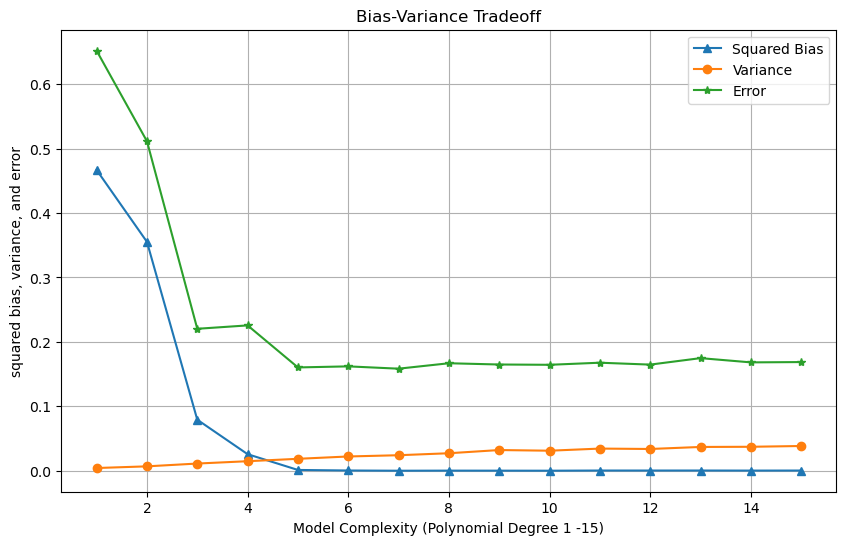

In [4]:
# generate dataset
def generate_dataset(size):
    x = np.linspace(0, 5, size)
    f_x = x + np.sin(1.5 * x)
    epsilon = np.random.normal(0, 0.3, size=size)
    y_x = f_x + epsilon
    return x, y_x

# Generate 100 datasets, size 50 and a common test set
# making sure all the datasets share this common test set but their training set is different.
np.random.seed(0) 
test_set_size = 10
training_set_size = 40
x_test, y_test = generate_dataset(test_set_size) 

# squared bias, variance, and error
max_degree = 15
squared_bias = np.zeros(max_degree)
variance = np.zeros(max_degree)
error = np.zeros(max_degree)


for degree in range(1, max_degree + 1):
    predictions = np.zeros((100, test_set_size))
    
    for i in range(100):
        x_train, y_train = generate_dataset(training_set_size)
        poly = PolynomialFeatures(degree=degree)
        x_train_poly = poly.fit_transform(x_train[:, np.newaxis])
        x_test_poly = poly.transform(x_test[:, np.newaxis])
        
        model = LinearRegression()
        model.fit(x_train_poly, y_train)
        predictions[i] = model.predict(x_test_poly)
    
    mean_predictions = np.mean(predictions, axis=0)
    squared_bias[degree - 1] = np.mean((mean_predictions - (x_test + np.sin(1.5 * x_test)))**2)
    variance[degree - 1] = np.mean(np.var(predictions, axis=0))
    error[degree - 1] = np.mean((predictions - y_test.reshape(1, -1))**2)

# Plotting
degrees = range(1, max_degree + 1)
plt.figure(figsize=(10, 6))
plt.plot(degrees, squared_bias, label='Squared Bias', marker='^')
plt.plot(degrees, variance, label='Variance', marker='o')
plt.plot(degrees, error, label='Error', marker='*')
plt.xlabel('Model Complexity (Polynomial Degree 1 -15)')
plt.ylabel('squared bias, variance, and error')
plt.title('Bias-Variance Tradeoff')
plt.legend()
plt.grid()
plt.show()


In [5]:
# table view for answering the question better.
metrics_df = pd.DataFrame({
    'Polynomial Degree': degrees,
    'Squared Bias': squared_bias,
    'Variance': variance,
    'Error': error
})
metrics_df

,Polynomial Degree,Squared Bias,Variance,Error
0,1,0.466722,0.004256,0.651836
1,2,0.355223,0.006847,0.511379
2,3,0.079227,0.011195,0.220323
3,4,0.025716,0.014823,0.225580
4,5,0.001258,0.018549,0.160352
5,6,0.000411,0.022165,0.161999
6,7,0.000064,0.024121,0.158417
7,8,0.000214,0.027191,0.166844
8,9,0.000159,0.032151,0.164888
9,10,0.000091,0.031120,0.164442


#### Written Answer to 1.3.b

Squared Bias decreases as model complexity increases. This is because more complex models can better capture the underlying function $f(x)$, thus reducing the error. $g_7(x)$ has the smallest error, of 0.1584.


Variance increases with model complexity. More complex models are more sensitive to fluctuations in the training data.

Error first decreases as complexity increases from underfitting models to more nicely fitting models. However, as the model becomes too complex, the error increases due to overfitting.

The best model would have a balance between bias and variance, minimizing the overall error. From the plot, it seems that models with a complexity, polynomial degree of **5**, could have a good balance, as beyond this range, variance starts to increase without a decrease in bias, leading to an increase in error. If we look at the number from the table and answering the question: $g_5(x)$ is the best model, with a error on test set of 0.16, a squared bias of 0.001258, and a variance of 0.0185.


## Problem 2 - KNN hyperparameter tuning using cross validation

### 2.1. train a KNN classifer

In [6]:
file_path = 'Social_Network_Ads.csv'
data = pd.read_csv(file_path)

data.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [7]:
dataset = pd.read_csv('Social_Network_Ads.csv')
X = dataset.iloc[:, [1, 2, 3]].values
y = dataset.iloc[:, -1].values

le = LabelEncoder()
X[:,0] = le.fit_transform(X[:,0])

# (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#  with K=4 and p=2 (Euclidean distance)
knn = KNeighborsClassifier(n_neighbors=4, p=2)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
misclassification_error = 1 - accuracy
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

misclassification_error, accuracy,precision, recall, f1


(0.08750000000000002, 0.9125, 0.92, 0.8214285714285714, 0.8679245283018867)

 #### Written Answer
 
 The misclassification_error is 0.0875, accuracy is 0.9125, the precision is 0.92, the recall is 0.82, and the f1 score is 0.87.

### 2.2. 5-fold cross-validation

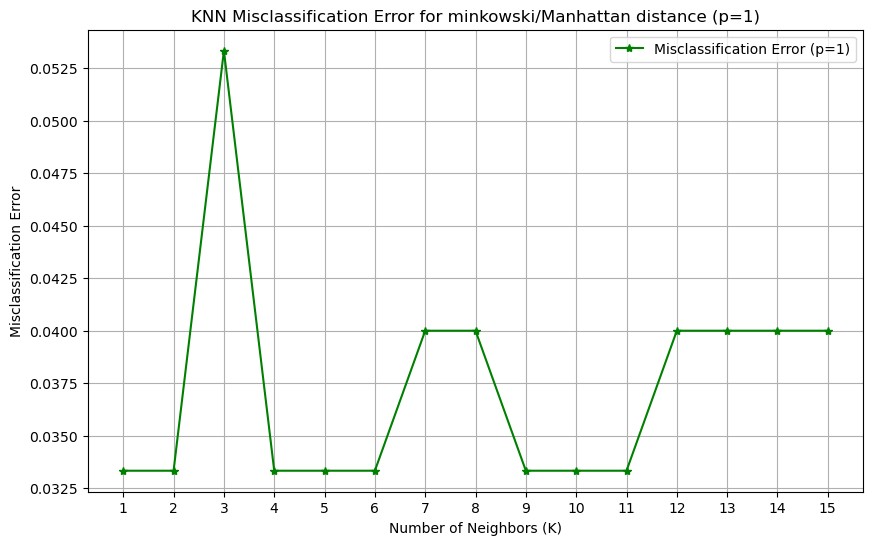

In [15]:
# K values to test
k_values = range(1, 16)

# Initialize for p=1
misclassification_errors_p1 = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric = 'minkowski', p=1)
  
    cv_scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
    
    misclassification_errors_p1.append(1 - np.mean(cv_scores))

# Plotting error for p=1
plt.figure(figsize=(10, 6))
plt.plot(k_values, misclassification_errors_p1, label='Misclassification Error (p=1)', 
         marker='*', linestyle='-', color='green')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Misclassification Error')
plt.title('KNN Misclassification Error for minkowski/Manhattan distance (p=1)')
plt.legend()
plt.xticks(k_values)
plt.grid()
plt.show()


### 2.3. 5-fold cross-validation

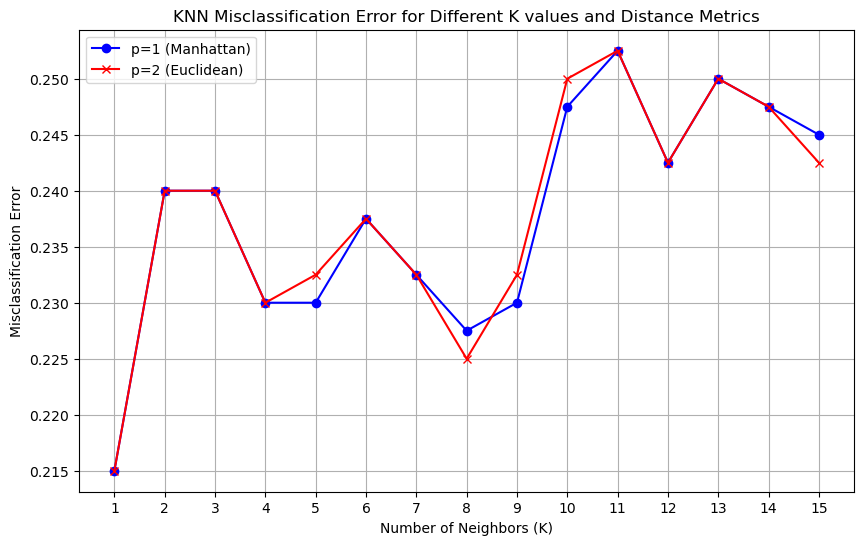

In [9]:

misclassification_errors_p2 = []

for k in k_values:
  
    knn = KNeighborsClassifier(n_neighbors=k, metric = 'minkowski', p=2)
    
    cv_scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')

    misclassification_errors_p2.append(1 - np.mean(cv_scores))

plt.figure(figsize=(10, 6))
plt.plot(k_values, misclassification_errors_p1, label='p=1 (Manhattan)', marker='o', linestyle='-', color='blue')
plt.plot(k_values, misclassification_errors_p2, label='p=2 (Euclidean)', marker='x', linestyle='-', color='red')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Misclassification Error')
plt.title('KNN Misclassification Error for Different K values and Distance Metrics')
plt.legend()
plt.xticks(k_values)
plt.grid()
plt.show()


### 2.4. Conclusion

In [10]:

misclassification_errors_df = pd.DataFrame({
    'Number of Neighbors (K)': k_values,
    'Misclassification Error (p=1)': misclassification_errors_p1,
    'Misclassification Error (p=2)': misclassification_errors_p2
})
misclassification_errors_df

,Number of Neighbors (K),Misclassification Error (p=1),Misclassification Error (p=2)
0,1,0.2150,0.2150
1,2,0.2400,0.2400
2,3,0.2400,0.2400
3,4,0.2300,0.2300
4,5,0.2300,0.2325
5,6,0.2375,0.2375
6,7,0.2325,0.2325
7,8,0.2275,0.2250
8,9,0.2300,0.2325
9,10,0.2475,0.2500


#### Written Answer

The best value of K with Euclidean distance is 1 (misclassification error is 0.2150). This is the value same as the Manhattan distance (when k=1 p=1, misclassification error is 0.2150). p = 2 (Euclidean) and K = 1 gives the best classifier, with a misclassification error at 0.2150, absolute smallest across all. 

## Problem 3 - Which Algorithm is Better

### 3.1. Written Answer

Create a confusion matrix for each of the two algorithms showing TP, FP, FN, TN.

True Positives (TP): The number of documents correctly identified as relevant by the algorithm.

False Positives (FP): The number of documents incorrectly identified as relevant (i.e., they are irrelevant but the algorithm flagged them as relevant).

False Negatives (FN): The number of relevant documents the algorithm failed to identify (i.e., they are relevant but the algorithm flagged them as irrelevant).

True Negatives (TN): The number of documents correctly identified as irrelevant by the algorithm.

<pre>
```
Confusion Matrix for Algorithm 1:
-----------------------------
               | Predicted Positive | Predicted Negative
Actual Positive | TP 25              | FN 5
Actual Negative | FP 15              | TN 55
-----------------------------

Confusion Matrix for Algorithm 2:
-----------------------------
               | Predicted Positive | Predicted Negative
Actual Positive | TP 20              | FN 10
Actual Negative | FP 10              | TN 60
-----------------------------
```
</pre>

### 3.2 Written Answer

Balanced Accuracy Calculation for Algorithm 1: $\frac{1}{2}(\frac{TP}{TP+FN} + \frac{TN}{TN+FP}) = \frac{1}{2} (\frac{25}{25+5} + \frac{55}{55+15}) = \frac{17}{21} = 0.81$

Balanced Accuracy Calculation for Algorithm 2: $\frac{1}{2}(\frac{TP}{TP+FN} + \frac{TN}{TN+FP}) = \frac{1}{2} (\frac{20}{20+10} + \frac{60}{60+10}) = \frac{16}{21} = 0.76$

Presion = $\frac{TP}{TP+FP}$

Recall = $\frac{TP}{TP+FN}$

F-1 Score = $2 \times \frac{Precision \times Recall}{Precision + Recall}$

F-1 Score Calculation for Algorithm 1 = $\frac{\frac{25}{40} \times \frac{25}{30}}{\frac{25}{40} + \frac{25}{30}} \times 2 = \frac{10}{14} = 0.714$

F-1 Score Calculation for Algorithm 2 = $\frac{\frac{20}{30} \times \frac{20}{30}}{\frac{20}{30} + \frac{20}{30}} \times 2 = \frac{2}{3} = 0.667$


Balanced Accuracy considers both the positive and negative classes equally, calculating the average accuracy across all classes. F1 Score, on the other hand, is the harmonic mean of precision and recall, focusing primarily on the positive class. It doesn't directly account for the performance on the negative class unless specifically recalculated for it, making it less suitable when the interest is explicitly in the performance on negative classes.

Given the focus on negative classes:
The friend's suggestion to use Balanced Accuracy is more appropriate here. Balanced Accuracy of Algorithm 1 is higher (0.81) than that of Algorithm 2 (0.76), indicating that Algorithm 1 performs better overall across both classes, including the negative class.

The instructor's suggestion to use the F1 Score would be more relevant if the interest were solely in the performance on the positive class. However, since the focus is on the negative classes, the F1 Score might not provide a complete picture of the algorithm's performance on those classes.

Therefore, the friend is right in this context because Balanced Accuracy better reflects the performance across both positive and negative classes.







### 3.3. Written Answer

Since the goal was to evaluate the algorithm's effectiveness on both positive and negative classes equally, Balanced Accuracy provided a clear insight into which algorithm performs better overall, including the negative class. Therefore, by Balanced Accuracy for Algorithm 1 (0.8095238095238095) was higher than for Algorithm 2 (0.7619047619047619), Algorithm 1 is better alogrithm. Their advice is helpful.

### 3.4. Written Answer

**Specificity (True Negative Rate)**: Measures the proportion of actual negatives correctly identified as such. It basically tell you the algorithm's ability to identify negative classes accurately. Specificity = $\frac{TN}{TN+FP}$

**Negative Predictive Value (NPV)**: Reflects the proportion of identified negatives that are truly negative. This helps understand the effectiveness of an algorithm in predicting negative outcomes. NPV = $\frac{TN}{TN+FN}$

**Balanced Accuracy**: As discussed, it is the average of the recall obtained on each class, $\frac{1}{2}(\frac{TP}{TP+FN} + \frac{TN}{TN+FP})$ 

These metrics, especially when used together, provide a better understanding of an algorithm's performance on both positive and negative classes.

## Problem 4 - Logistic Regression with Regularization

### 4.1. Written Answer

**C**: basically an inverse of regularization strength; smaller values specify stronger regularization. Usually, a high value of C tells the model to give a high importance to the training data, whereas a low value pushes the model to a simpler decision boundary to avoid overfitting.

**Solver**: Algorithm to use for optimization problem. Different solvers support different penalty terms and have different performance characteristics.

**Penalty**: the norm used in the penalization (regularization). Common values are 'l1', 'l2', and sometimes 'elasticnet' (a combination of both 'l1' and 'l2'). Silimilar to lab2 introduced concept. 

**Multi_class**: Determines the approach used for handling multiple classes. Options include 'ovr' (one-vs-rest, suitable for binary problems and as a strategy for multiclass problems) and 'multinomial' (for multinomial logistic regression).

### 4.2. Written Answer

**'l1' penalty**: It is Lasso regularization. It tends to lead to sparse solutions, where a subset of the weights becomes exactly zero. This can be useful for feature selection by dropping non-informative features.

**'l2' penalty**: It is Ridge regularization. It distributed the error among all the weights, typically leading to small but non-zero weights. This manages multicollinearity and model complexity without necessarily eliminating features.


### 4.3. Logistic Regression Models w/ Regularization

Input variables for the dataset are: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
C values:  [1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05]


/Users/zhongyihao/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/zhongyihao/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/zhongyihao/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/zhongyihao/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/zhongyihao/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/zhongyihao/anaconda3/lib/python3.10/site-packages/sklearn/svm/_

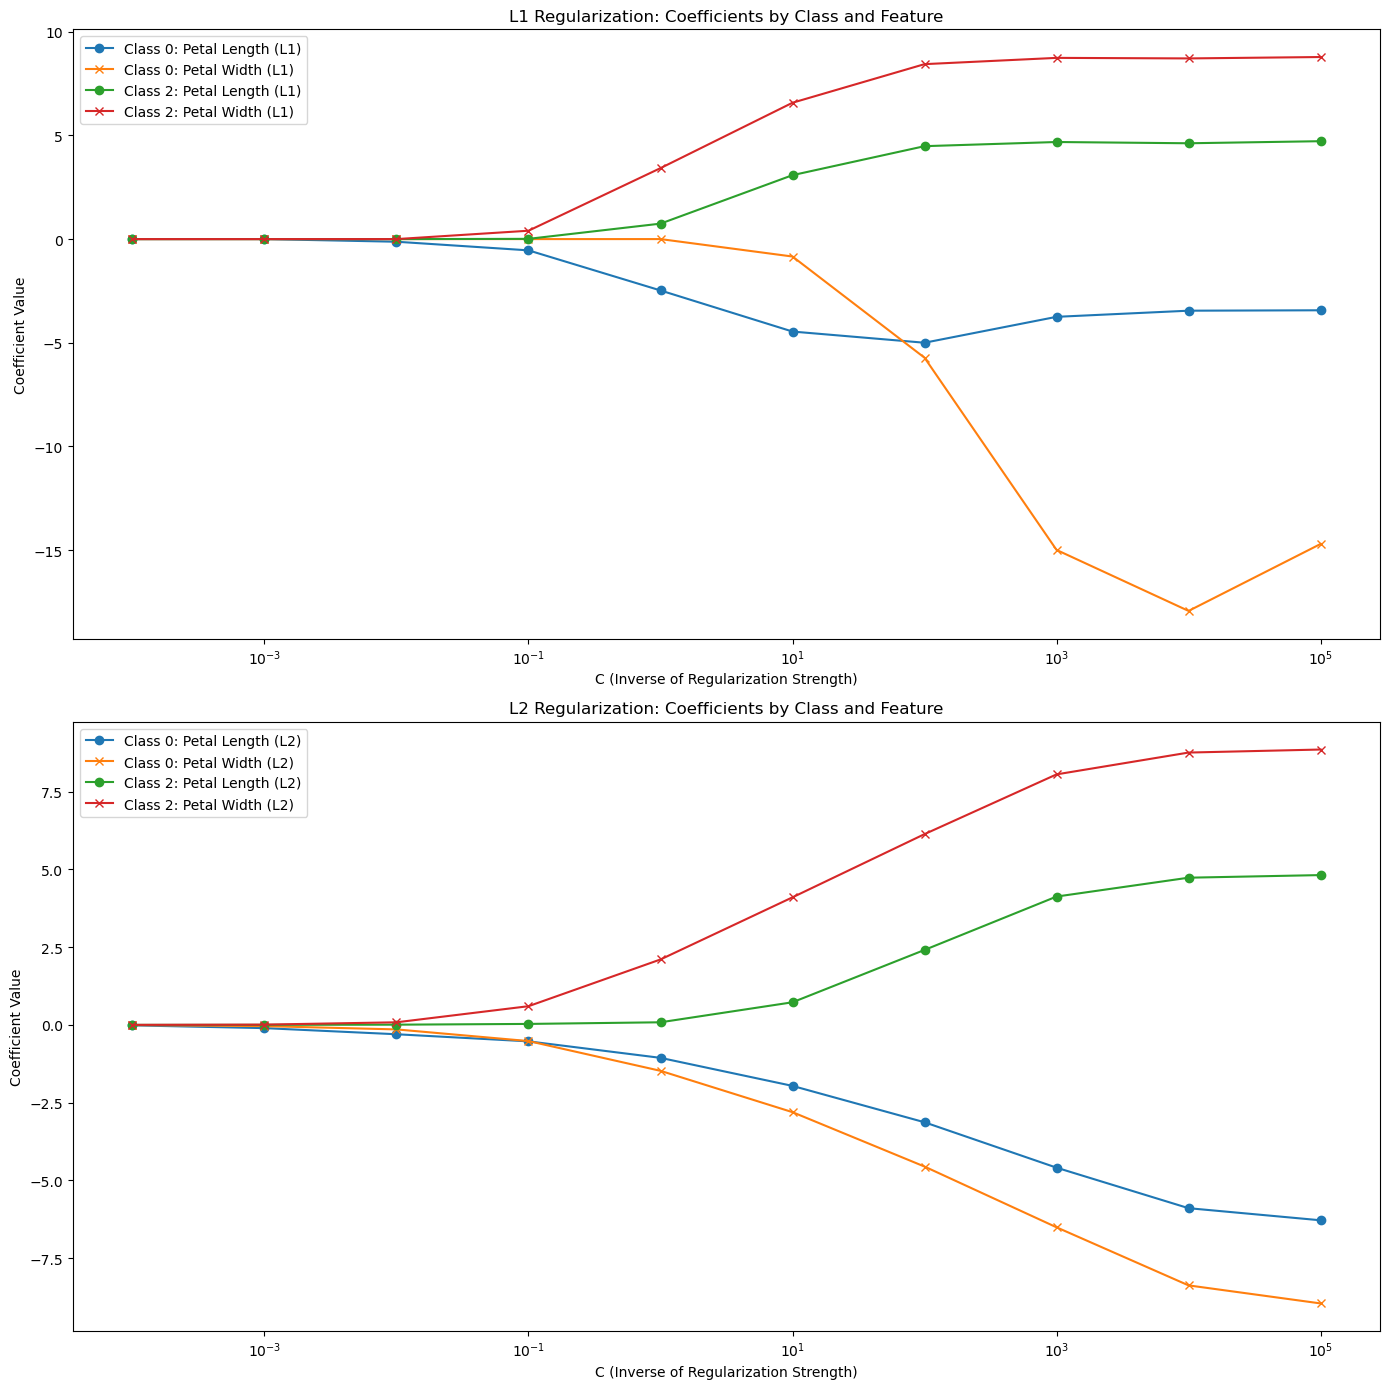

In [11]:
iris = load_iris()
print("Input variables for the dataset are:", iris.feature_names)
X = iris.data[:, 2:]  # only petal length and petal width
y = iris.target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Range of C 
C_values = np.logspace(-4, 5, 10)
print("C values: ", C_values)

weights_l1_class0 = []
weights_l2_class0 = []
weights_l1_class2 = []
weights_l2_class2 = []
norm_weights_l1 = []
norm_weights_l2 = []

for C in C_values:
    model_l1 = LogisticRegression(C=C, penalty='l1', solver='liblinear', multi_class='ovr').fit(X_train, y_train)
    weights_l1_class0.append(model_l1.coef_[0])  
    weights_l1_class2.append(model_l1.coef_[2])  
    norm_weights_l1.append(np.linalg.norm(model_l1.coef_))

    
    # L2 Regularization Model
    model_l2 = LogisticRegression(C=C, penalty='l2', solver='liblinear', multi_class='ovr').fit(X_train, y_train)
    weights_l2_class0.append(model_l2.coef_[0])  
    weights_l2_class2.append(model_l2.coef_[2])  
    norm_weights_l2.append(np.linalg.norm(model_l2.coef_))




weights_l1_class0 = np.array(weights_l1_class0)
weights_l2_class0 = np.array(weights_l2_class0)
weights_l1_class2 = np.array(weights_l1_class2)
weights_l2_class2 = np.array(weights_l2_class2)



plt.figure(figsize=(14, 14))

plt.subplot(2, 1, 1)
plt.plot(C_values, weights_l1_class0[:, 0], label='Class 0: Petal Length (L1)', marker='o')
plt.plot(C_values, weights_l1_class0[:, 1], label='Class 0: Petal Width (L1)', marker='x')
plt.plot(C_values, weights_l1_class2[:, 0], label='Class 2: Petal Length (L1)', marker='o')
plt.plot(C_values, weights_l1_class2[:, 1], label='Class 2: Petal Width (L1)', marker='x')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Coefficient Value')
plt.title('L1 Regularization: Coefficients by Class and Feature')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(C_values, weights_l2_class0[:, 0], label='Class 0: Petal Length (L2)', marker='o')
plt.plot(C_values, weights_l2_class0[:, 1], label='Class 0: Petal Width (L2)', marker='x')
plt.plot(C_values, weights_l2_class2[:, 0], label='Class 2: Petal Length (L2)', marker='o')
plt.plot(C_values, weights_l2_class2[:, 1], label='Class 2: Petal Width (L2)', marker='x')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Coefficient Value')
plt.title('L2 Regularization: Coefficients by Class and Feature')
plt.legend()

plt.tight_layout()
plt.show()

#### 4.3. Written Answer

By observing the 2 graphs and 8 lines, we can tell clear patterns that match how l1 and l2 works.

For L1: As the value of C decreases (stronger regularization), more coefficients are converage to 0 from both direction, in an aggresive way When regularization decrease, some features are not repsonding to it(instead they steadily converage to some certain smaller range). By this it shows taht L1 simplifies the model by performing feature selection. Basically, the 'l1' regularization is expected to potentially zero out some coefficients, particularly for features less critical for classification of certain classes, demonstrating feature selection. This can lead to models that are easier to interpret but may underfit if regularization is too strong.


For L2: All coefficients are grow towards bigger coefficient value, in a certain speed per features.. This means L2 regularization does not inherently perform feature selection but rather ensures that no single feature dominates the model, which can help prevent overfitting especially in cases of multicollinearity. In another way, as gave in the lecture: 'l2' regularization would show a more uniform shrinkage of coefficients across features and classes, maintaining their contribution but reducing their magnitude to prevent overfitting.

What's more, the l2 plot of coefficient against C values show a gradual decrease or increase without the sharp cutoffs to zero that has seen with l1. This means that l2 regularization maintains all features but balances their influence on the model.

### 4.4. Analysis of Regularization effects

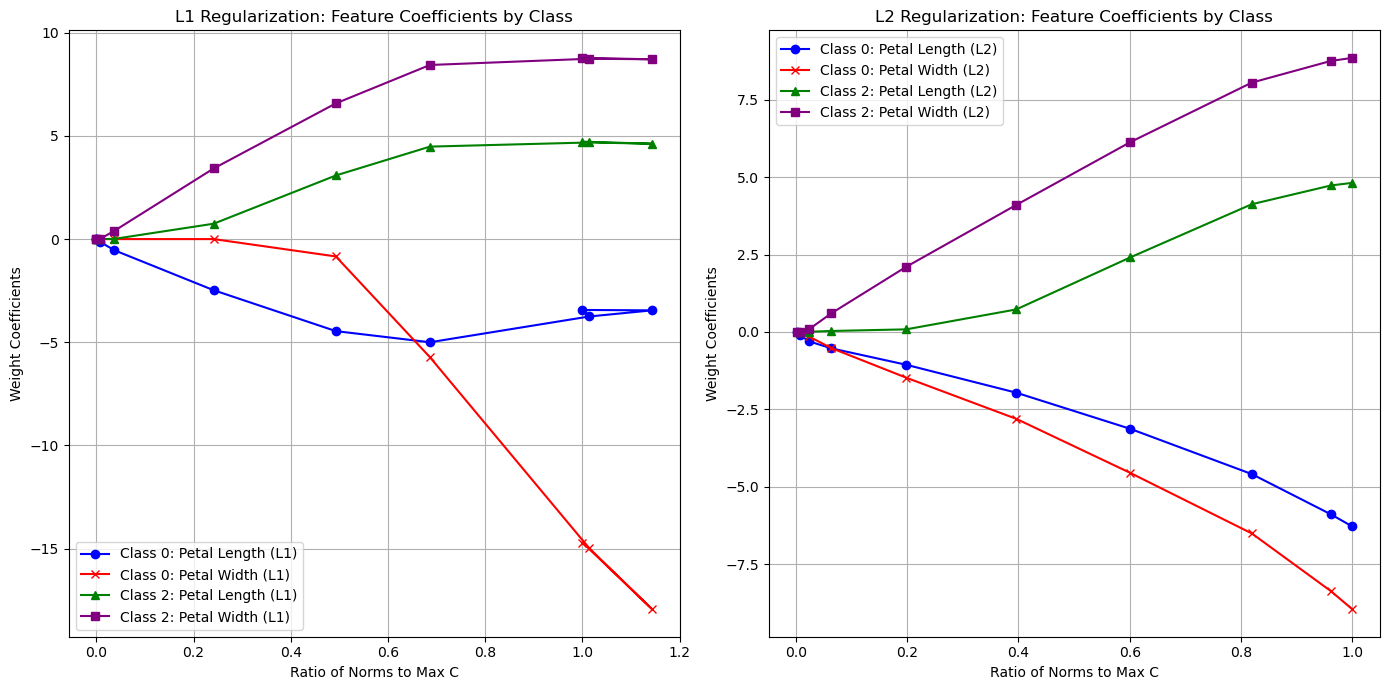

In [12]:
ratio_l1 = []
for i, C in enumerate(C_values):
    ratio_l1.append(np.linalg.norm(norm_weights_l1[i]) / np.linalg.norm(norm_weights_l1[-1]))

ratio_l2 = []
for i, C in enumerate(C_values):
    ratio_l2.append(np.linalg.norm(norm_weights_l2[i]) / np.linalg.norm(norm_weights_l2[-1]))

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)

plt.plot(ratio_l1, weights_l1_class0[:, 0], label='Class 0: Petal Length (L1)' , color='blue', marker='o')
plt.plot(ratio_l1, weights_l1_class0[:, 1], label='Class 0: Petal Width (L1)' , color='red', marker='x')
plt.plot(ratio_l1, weights_l1_class2[:, 0], label='Class 2: Petal Length (L1)' , color='green', marker='^')
plt.plot(ratio_l1, weights_l1_class2[:, 1], label='Class 2: Petal Width (L1)' , color='purple', marker='s')
plt.ylabel('Weight Coefficients')
plt.xlabel('Ratio of Norms to Max C')
plt.title('L1 Regularization: Feature Coefficients by Class')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)

plt.plot(ratio_l2, weights_l2_class0[:, 0], label='Class 0: Petal Length (L2)' , color='blue', marker='o')
plt.plot(ratio_l2, weights_l2_class0[:, 1], label='Class 0: Petal Width (L2)' , color='red', marker='x')
plt.plot(ratio_l2, weights_l2_class2[:, 0], label='Class 2: Petal Length (L2)' , color='green', marker='^')
plt.plot(ratio_l2, weights_l2_class2[:, 1], label='Class 2: Petal Width (L2)' , color='purple', marker='s')
plt.ylabel('Weight Coefficients')
plt.xlabel('Ratio of Norms to Max C')
plt.title('L2 Regularization: Feature Coefficients by Class')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()



#### 4.4. Written Answer

The graphs look similar to what shown in lecture slides.

In general, A higher ratio indicates a model closer to being unregularized (potentially overfitted), while a lower ratio indicates a model that is more regularized and possibly simpler (but at risk of underfitting if over-regularized).

Again, it shows that l2 regularization maintains all features but balances their influence on the model, while L1 simplifies the model by performing feature selection. 

More, in the L1 plot, we can see that as the regularization strength increases (ratio decreases), the coefficients for both features in both classes approach zero, with some coefficients reaching zero earlier at higher regularization strengths (red line arrive at 0 around a ratio of 0.25). It means difference features responds differently.Here the red line says: The coefficients for both features in class 0 decrease substantially as the regularization strength increases. This is indicative of the 'l1' regularization's ability to produce sparse models, where irrelevant features can be eliminated (sometime coefficients set to zero while other features are not). The coefficients for both features in class 0 decrease substantially as the regularization strength increases


Unlike L1 regularization, L2 does not zero out coefficients but rather shrinks them smoothly as regularization strength increases. L2 regularization smoothly penalizes larger coefficients, maintaining all features but with reduced influence as the regularization strength increases. The coefficients for class 0 show a steady decrease, with the coefficient for petal width decreasing more than that for petal length. In class 2, the petal length's coefficient decreases but remains positive, again reflecting its importance for the model. In class 2, the petal length's coefficient decreases but remains positive, again reflecting its importance for the model.